In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import cv2
import numpy as np
from PIL import Image
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import pandas as pd
from rembg import remove

In [54]:
def load_dataset():
    """
    The `load_dataset` function downloads and extracts the Caltech 101 dataset, then creates a dataframe
    containing paths to all image files in the dataset.
    :return: The function `load_dataset()` returns a pandas DataFrame containing the paths to all the
    image files (with the extension .jpg) found in the subfolders of the directory
    "./101_ObjectCategories".
    """
    # load Caltech 101 database from https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1

    os.system("wget https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip")
    os.system("unzip caltech-101.zip")

    os.system("tar -xf ./caltech-101/101_ObjectCategories.tar.gz")

    # parse directory /101_ObjectCategories into a dataframe of images, in all subfolders

    image_paths = []
    for root, dirs, files in os.walk("./101_ObjectCategories"):
        for file in files:
            if file.endswith(".jpg"):
               image_paths.append(os.path.join(root, file))

    df_images = pd.DataFrame({"path": image_paths})
    return df_images


def remove_background(path):
    """
    The function `remove_background` takes an image file path as input, removes the background from the
    image, fills the background with white color, resizes the image, and returns the modified image.

    :param path: The `path` parameter in the `remove_background` function is a string that represents
    the file path to an image file. This function seems to be designed to remove the background from an
    image using OpenCV and then resize the resulting image
    :return: the variable `output`, which is the result of processing the input image to remove the
    background and then resizing it.
    """
    input = Image.open(path)
    pil_output = remove(input)
    output = np.asarray(pil_output)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    cv2.floodFill(output, None, (0, 0), (255, 255, 255))
    img = cv2.resize(output, (0,0), fx = 0.5, fy = 0.5)
    return img

In [ ]:
load_dataset()

,path
0,./101_ObjectCategories/scorpion/image_0067.jpg
1,./101_ObjectCategories/scorpion/image_0082.jpg
2,./101_ObjectCategories/scorpion/image_0015.jpg
3,./101_ObjectCategories/scorpion/image_0057.jpg
4,./101_ObjectCategories/scorpion/image_0068.jpg
...,...
9139,./101_ObjectCategories/rooster/image_0045.jpg
9140,./101_ObjectCategories/rooster/image_0023.jpg
9141,./101_ObjectCategories/rooster/image_0024.jpg
9142,./101_ObjectCategories/rooster/image_0002.jpg


In [55]:



class DitheringMaker:
    """
    Class for applying Floyd-Steinberg dithering to images.

    Floyd-Steinberg dithering is a technique for converting grayscale images
    to black and white while preserving detail by diffusing quantization errors
    to neighboring pixels.
    """

    def __init__(self):
        """
        Initializes the DitheringMaker with the error diffusion proportions.
        """
        # Error diffusion proportions for Floyd-Steinberg dithering
        # Arrangement:
        # _     x     7/16
        # 3/16  5/16  1/16
        self.diffusion_prop = np.array([[0, 0, 7], [3, 5, 1]]) / 16


    def make_dithering(self, pixels, cutoff=255 / 2):
        """
        Applies Floyd-Steinberg dithering to the input image.

        Args:
            pixels (np.array): The input image as a NumPy array.
            cutoff (float, optional): The threshold for determining black/white pixels. Defaults to 127.5.

        Returns:
            np.array: The dithered image as a NumPy array.
        """

        # Create a working copy of the image as float for calculations
        dithering = pixels.copy().astype('float')
        n_rows, n_cols = pixels.shape

        # Initialize the first column to be white (assuming background color)
        dithering[:, 0] = 255

        # Pre-calculate row and column offsets for error diffusion
        row_disp = np.full((2, 3), np.arange(0, 2)[:, np.newaxis], dtype='int')
        col_disp = np.full((2, 3), np.arange(-1, 2), dtype='int')

        # Iterate over each row (except the last) and column (except first and last)
        for row in range(n_rows - 1):
            for col in range(1, n_cols - 1):
                old_pixel = dithering[row, col]

                # Apply dithering: set pixel to black or white based on cutoff
                new_pixel = 255.0 if old_pixel > cutoff else 0.0
                dithering[row, col] = new_pixel

                # Calculate the quantization error
                error = old_pixel - new_pixel

                # Distribute the error to neighboring pixels using diffusion proportions
                dithering[row + row_disp, col + col_disp] += error * self.diffusion_prop

        # Make the last column and the last row all white (border pixels)
        dithering[:, -1] = 255
        dithering[-1, :] = 255

        # Convert the dithered image back to integers (black/white)
        return dithering.astype('int')


def get_vertices(dithering):
    """
    Extracts vertices from a black and white (dithered) image.

    Args:
        dithering (np.array): The dithered image as a NumPy array.

    Returns:
        np.array: An array of shape (n_vertices, 2) containing the xy-coordinates of the vertices.
    """

    n_rows, n_cols = dithering.shape
    keep_pixel_mask = (dithering == 0)  # Mask for black pixels (vertices)

    rows, cols = np.mgrid[:n_rows, :n_cols]  # Create row and column indices
    rows, cols = rows[keep_pixel_mask], cols[keep_pixel_mask]  # Filter by mask

    vertices = np.stack([cols, n_rows - 1 - rows], axis=-1)  # Create vertex coordinates (invert y-axis)
    return vertices


def get_pixels(image, downsample_factor=1):
    """
    Converts a PIL image to a NumPy array with optional downsampling.

    Args:
        image (PIL.Image): The PIL image to convert.
        downsample_factor (int, optional): Downsampling factor. Defaults to 1 (no downsampling).

    Returns:
        np.array: A 2D NumPy array of pixel values (mean of downsampled regions if applicable).
    """

    ds = downsample_factor
    imwidth, imheight = image.size
    pixels = np.array(list(image.getdata())).reshape((imheight, imwidth))  # Get pixel data as NumPy array

    # Downsample by taking the mean of ds x ds sub-squares
    downsampled_pixels = np.array([[pixels[i:i+ds, j:j+ds].mean()
                                    for j in range(0, imwidth, ds)]
                                   for i in range(0, imheight, ds)])
    return downsampled_pixels



In [59]:
# This Python class implements a Genetic Algorithm for solving the Traveling Salesman Problem (TSP)
# using DEAP, with methods for processing images, optimizing paths, and plotting the results.
class TSP_GA:
    def __init__(self, image_path, population_size=50, ngen=10):
        """
        The function initializes parameters for an evolutionary algorithm with a specified image path,
        population size, and number of generations.

        :param image_path: The `image_path` parameter in the `__init__` method is a string that
        represents the path to an image file. This path will be used by the class or function to load
        and process the image data
        :param population_size: The `population_size` parameter represents the number of individuals in
        the population for a genetic algorithm. In this context, it specifies the size of the population
        used in the genetic algorithm optimization process for the given image path, defaults to 200
        (optional)
        :param ngen: The `ngen` parameter represents the number of generations
        for which the genetic algorithm will run. It determines how many iterations or generations of
        the genetic algorithm will be executed to evolve the population towards a solution, defaults to
        10 (optional)
        """
        self.image_path = image_path
        self.population_size = population_size
        self.ngen = ngen
        self.toolbox = base.Toolbox()
        self.best_paths = []
        if not hasattr(creator, "FitnessMin"):
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
            creator.create("Individual", list, fitness=creator.FitnessMin)


    def evaluate(self, individual):
        """
        The function evaluates the total length of a path based on a given individual's sequence.

        :param individual: The `individual` parameter in the `evaluate` function represents a specific
        path or route in a traveling salesman problem. It is a list of nodes representing the order in
        which the salesman visits the cities. The function calculates the total length of the path by
        summing the distances between consecutive nodes in the `
        :return: A tuple containing the total length of the path is being returned.
        """
        distance_matrix = self.distance_matrix
        tour_length = sum(distance_matrix[individual[i - 1], individual[i]] for i in range(len(individual)))
        return (tour_length,)


    def calculate_distance_matrix(self, vertices):
        """
        The function calculates the Euclidean distance matrix between given vertices.

        :param vertices: The `vertices` parameter is a numpy array containing the coordinates of the
        vertices in a multidimensional space. Each row of the array represents the coordinates of a
        single vertex. The function `calculate_distance_matrix` calculates the Euclidean distance
        between each pair of vertices and returns a matrix where the element at position
        :return: The function `calculate_distance_matrix` returns the Euclidean distance matrix between
        the input vertices.
        """
        return np.sqrt(((vertices[:, np.newaxis, :] - vertices[np.newaxis, :, :]) ** 2).sum(axis=2))


    def two_opt(self, individual):
        """
        The `two_opt` function implements a 2-opt optimization algorithm to improve a given individual's
        path based on a distance matrix.

        :param individual: The `individual` parameter in the `two_opt` function represents a list that
        contains the order of visiting nodes in a tour. Each element in the list represents a node, and
        the order of the nodes determines the sequence of visiting them in the tour. The function
        applies a 2-opt optimization technique
        :return: The `two_opt` function is returning the optimized individual after applying the 2-opt
        optimization technique. The optimized individual is returned as a tuple containing the
        individual itself.
        """
        improved = True
        while improved:
            improved = False
            for i in range(1, len(individual) - 2):
                for j in range(i + 2, len(individual) - 1):
                    if self.distance_matrix[individual[i - 1]][individual[i]] + \
                        self.distance_matrix[individual[j]][individual[j + 1]] > \
                        self.distance_matrix[individual[i - 1]][individual[j]] + \
                        self.distance_matrix[individual[i]][individual[j + 1]]:
                        individual[i:j + 1] = reversed(individual[i:j + 1])
                        improved = True
        return individual,


    def setup_toolbox(self):
        """
        Sets up a DEAP toolbox for evolutionary algorithms.
        """
        self.toolbox.register("indices", random.sample, range(len(self.vertices)), len(self.vertices))
        self.toolbox.register("individual", tools.initIterate, creator.Individual, self.toolbox.indices)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("mate", tools.cxOrdered)
        self.toolbox.register("mutate", self.two_opt)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate)


    def process_image(self, image):
        """
        The `process_image` function processes an input image for TSP solving by downsampling, dithering,
        extracting vertices, calculating distance matrix, and setting up a toolbox.

        :param image: The `image` parameter is the input image that will be processed for solving the
        Traveling Salesman Problem (TSP). The image will be used to extract pixels, create a dithered
        version of the image, obtain vertices from the dithered image, and calculate a distance matrix based
        on
        """
        pixels = get_pixels(image, downsample_factor=3)
        ditherer = DitheringMaker()
        dithered_image = ditherer.make_dithering(pixels)
        self.vertices = get_vertices(dithered_image)
        self.distance_matrix = self.calculate_distance_matrix(self.vertices)
        self.setup_toolbox()


    def ga_algorithm(self):
        """
        The function `ga_algorithm` implements a genetic algorithm using the DEAP library to
        optimize a population of individuals.
        :return: The code is returning the best individual found by the genetic algorithm after running the
        evolutionary algorithm using the `eaSimple` function. The best individual is stored in the
        HallOfFame object `hof`, and the code returns this best individual by accessing it using
        `hof.items[0]`.
        """
        pop = self.toolbox.population(n=self.population_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.average)
        algorithms.eaSimple(pop, self.toolbox, cxpb=0.7, mutpb=0.2, ngen=self.ngen, stats=stats, halloffame=hof, verbose=True)
        return hof.items[0]


    def solve(self):
        """
        This function opens an image, processes it, runs a genetic algorithm to find the best solution, and
        then plots the path of the best solution.
        """
        image = Image.open(self.image_path).convert('L')
        self.process_image(image)
        best_solution = self.ga_algorithm()
        self.plot_path(best_solution)


    def solve_color(self):
        """
        This function solves the Traveling Salesman Problem (TSP) for color images by splitting the
        image into its RGB channels, processing each channel separately, applying a genetic algorithm to
        find the best path, and plotting the paths.
        """
        b, g, r = cv2.split(cv2.imread(self.image_path))
        b_pil = Image.fromarray(b)
        g_pil = Image.fromarray(g)
        r_pil = Image.fromarray(r)

        counter = 0
        colors = ['blue', 'green', 'red']

        for image in [b_pil, g_pil, r_pil]:
            print('Solving TSP for', colors[counter])
            self.process_image(image)
            best_solution = self.ga_algorithm()
            self.best_paths.append([self.vertices[i] for i in best_solution] + [self.vertices[best_solution[0]]])
            self.plot_path(best_solution)
            counter += 1

        self.plot_path_color(self.best_paths)


    def plot_path(self, best_solution):
        '''
        Plot the best path found by the solver.
        '''
        best_path = [self.vertices[i] for i in best_solution] + [self.vertices[best_solution[0]]]
        x, y = zip(*best_path)
        plt.figure()
        plt.plot(x, y, '-o', markersize=2, linewidth=1)
        plt.title("Best Path")
        plt.show()


    def plot_path_color(self, best_paths):
        """
        The function `plot_path_color` plots three paths in different colors on a black background.

        :param best_paths: Solutions for TSPs of each color respectively.
        """
        x_b, y_b = zip(*best_paths[0])

        x_g, y_g = zip(*best_paths[1])
        x_r, y_r = zip(*best_paths[2])

        fig, ax = plt.subplots()
        ax.set_facecolor('black')

        # Plotting all the curves simultaneously
        ax.plot(x_r, y_r, '-o', markersize=2, linewidth=1, alpha=0.8,
                 color='cyan')  # inverse for red
        ax.plot(x_g, y_g, '-o', markersize=2, linewidth=1, alpha=0.8,
                 color='magenta') # inverse for green
        ax.plot(x_b, y_b, '-o', markersize=2, linewidth=1, alpha=0.8,
                 color='yellow') # inverse for blue

        plt.title("Colorful TSP art")
        plt.show()


Preparing images from dataset

In [57]:
image1 = remove_background("./101_ObjectCategories/rooster/image_0002.jpg")
cv2.imwrite('./exp1.png', image1)

image2 = remove_background("./101_ObjectCategories/bonsai/image_0005.jpg")
cv2.imwrite('./exp2.png', image2)

image3 = remove_background("./101_ObjectCategories/butterfly/image_0002.jpg")
cv2.imwrite('./exp3.png', image3)

image4 = remove_background("./101_ObjectCategories/flamingo/image_0001.jpg")
cv2.imwrite('./exp4.png', image4)

image5 = remove_background("./101_ObjectCategories/water_lilly/image_0002.jpg")
cv2.imwrite('./exp5.png', image5)

image6 = remove_background("./101_ObjectCategories/stop_sign/image_0003.jpg")
cv2.imwrite('./exp6.png', image6)

image7 = remove_background("./101_ObjectCategories/pyramid/image_0002.jpg")
cv2.imwrite('./exp7.png', image7)

image8 = remove_background("./101_ObjectCategories/octopus/image_0004.jpg")
cv2.imwrite('./exp8.png', image8)

image9 = remove_background("./101_ObjectCategories/lotus/image_0001.jpg")
cv2.imwrite('./exp9.png', image9)

image10 = remove_background("./101_ObjectCategories/dolphin/image_0002.jpg")
cv2.imwrite('./exp10.png', image10)

True

Experiments with dataset

Solving TSP for blue
gen	nevals	min    	avg  
0  	50    	13902.8	14370
1  	43    	916.783	11586.1
2  	44    	910.297	7416.81
3  	36    	910.419	2558.15
4  	33    	910.419	971.406
5  	36    	910.411	955.114
6  	32    	906.891	949.552
7  	40    	906.517	944.656
8  	31    	906.517	945.121
9  	33    	903.925	938.674
10 	42    	899.148	942.272


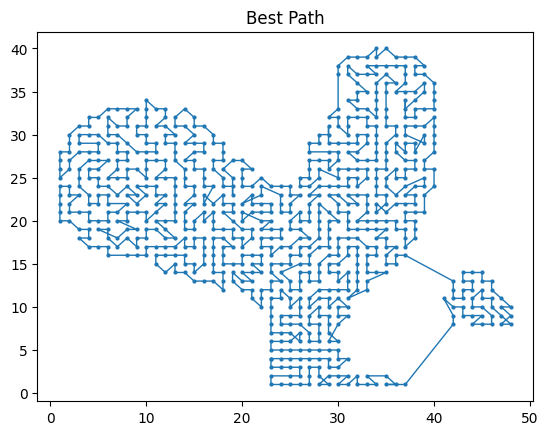

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	12497.5	12934.2
1  	44    	855.482	10638.3
2  	37    	843.967	6518.1 
3  	32    	843.967	2033.78
4  	42    	839.681	1091.65
5  	35    	842.726	907.541
6  	37    	842.726	886.83 
7  	36    	834.513	880.727
8  	35    	836.242	886.738
9  	40    	833.787	881.415
10 	39    	827.868	888.607


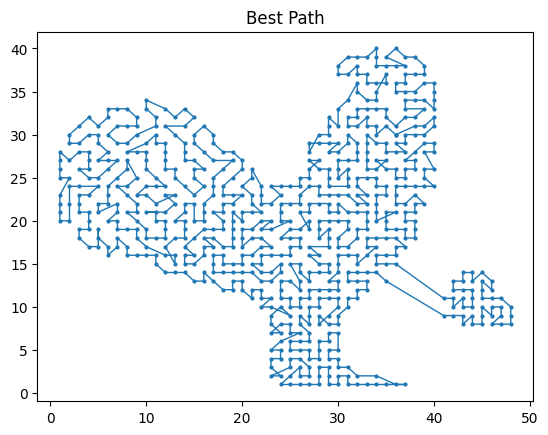

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	11221.4	11634.5
1  	44    	806.854	9140.24
2  	35    	794.982	5547.73
3  	39    	780.498	1315.56
4  	37    	780.498	837.109
5  	38    	780.498	829.785
6  	34    	779.965	824.876
7  	43    	775.187	841.038
8  	39    	775.187	842.247
9  	37    	775.187	810.075
10 	33    	775.187	804.509


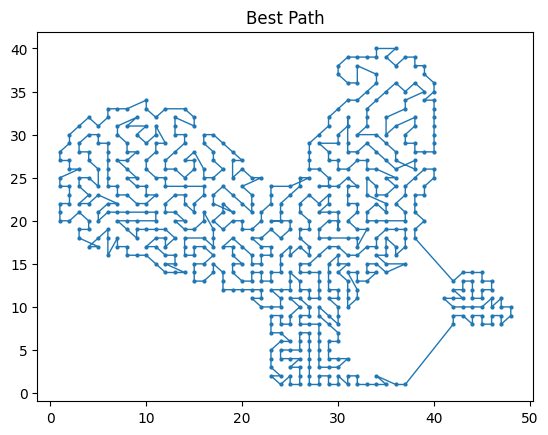

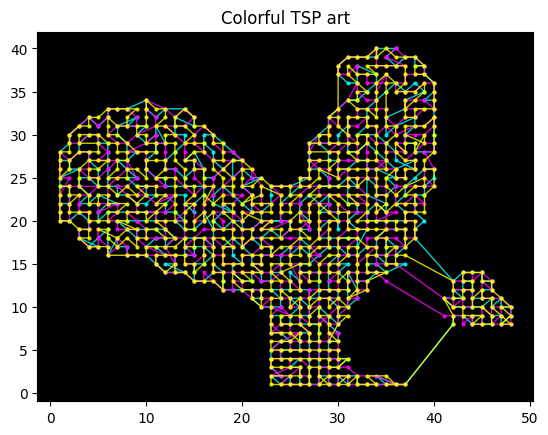

Solving TSP for blue
gen	nevals	min    	avg  
0  	50    	15976.4	16438
1  	37    	1081.17	14500.5
2  	38    	1076.55	10182.6
3  	43    	1066.14	3204.13
4  	39    	1060.69	1259.01
5  	38    	1070.2 	1162.43
6  	37    	1064.28	1143   
7  	41    	1061.67	1138.82
8  	36    	1061.67	1119.76
9  	42    	1056.1 	1114.26
10 	40    	1052.74	1101.34


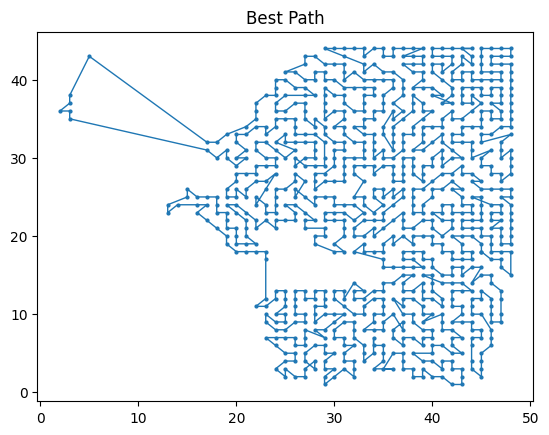

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	13938.1	14394.2
1  	36    	989.231	12571.1
2  	39    	995.018	8068.22
3  	35    	977.474	2868.21
4  	34    	971.627	1069.87
5  	34    	977.474	1040.65
6  	44    	969.286	1035.75
7  	43    	958.232	1039.23
8  	37    	958.232	1027.61
9  	37    	957.225	1020.68
10 	34    	957.225	1015.86


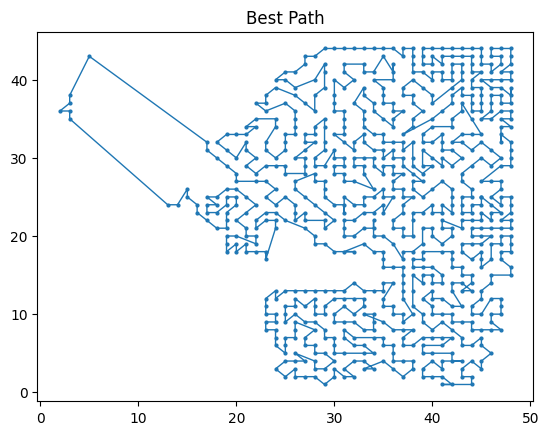

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	14552.9	15143.5
1  	30    	1030.23	13898.7
2  	37    	1020.65	8991.05
3  	41    	1008.29	3173.48
4  	31    	1008.29	1057.27
5  	34    	997.383	1056.7 
6  	44    	997.383	1060.96
7  	42    	996.943	1058.32
8  	36    	996.435	1052.46
9  	40    	992.879	1048.86
10 	34    	992.879	1047.78


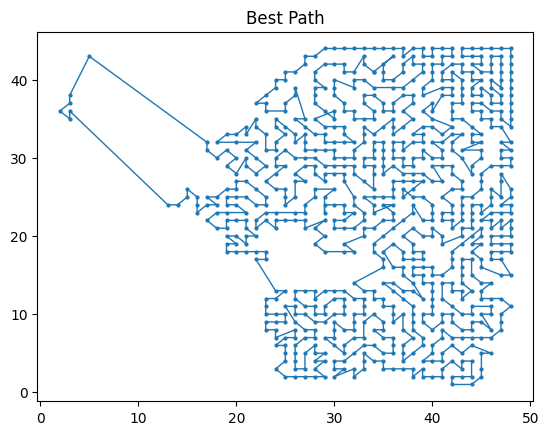

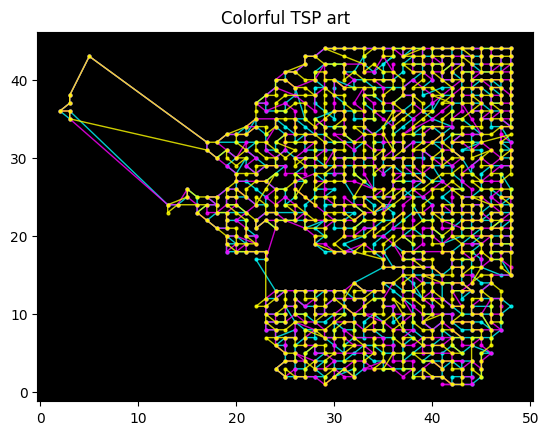

Solving TSP for blue
gen	nevals	min    	avg    
0  	50    	4520.24	4711.07
1  	41    	449.188	3964.5 
2  	39    	449.188	2610.67
3  	34    	441.677	1002.18
4  	30    	443.702	493.854
5  	30    	443.702	473.518
6  	41    	443.702	469.082
7  	39    	440.491	478.638
8  	37    	438.796	470    
9  	36    	438.796	463.345
10 	37    	436.939	460.528


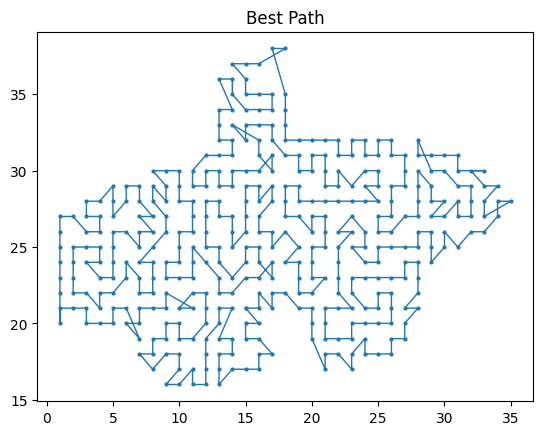

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	3886.85	4175.61
1  	38    	408.922	3008.49
2  	37    	407.079	1350.01
3  	35    	400.468	543.714
4  	44    	401.845	438.462
5  	38    	405.399	438.001
6  	33    	404.09 	431.962
7  	41    	403.096	433.844
8  	41    	402.52 	423.817
9  	40    	400.685	429.101
10 	38    	398.313	421.996


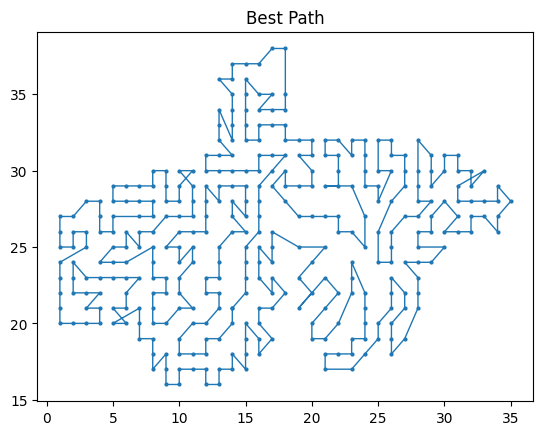

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	3088.15	3301.83
1  	36    	346.417	2607.54
2  	34    	342.011	1372.66
3  	34    	339.85 	448.924
4  	37    	336.495	361.037
5  	42    	337.226	360.869
6  	41    	335.537	362.621
7  	41    	335.43 	365.704
8  	31    	331.161	358.503
9  	30    	331.161	346.144
10 	37    	327.66 	346.251


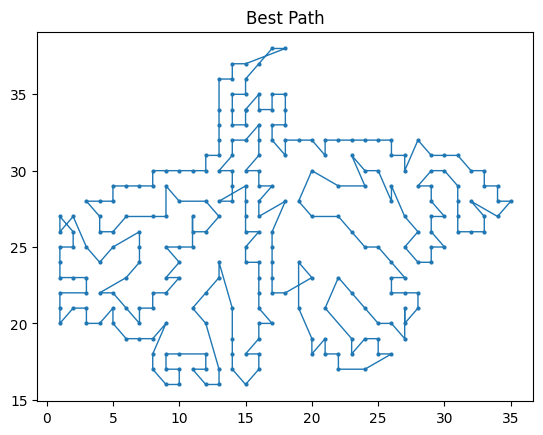

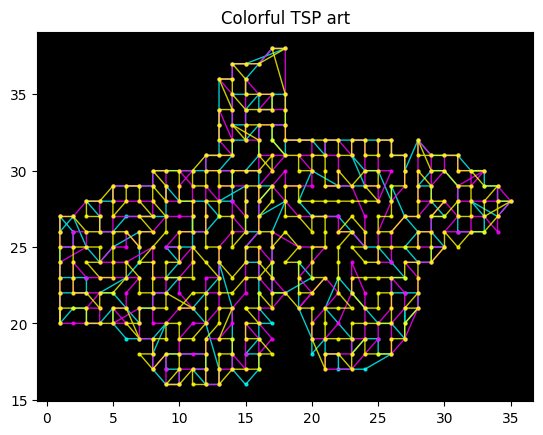

Solving TSP for blue
gen	nevals	min    	avg   
0  	50    	2838.23	3079.8
1  	41    	301.288	2397.39
2  	30    	301.288	1324.21
3  	32    	298.782	447.91 
4  	42    	294.977	333.897
5  	42    	294.977	337.797
6  	43    	297.573	340.954
7  	33    	292.1  	323.984
8  	42    	292.934	335.82 
9  	33    	290.564	325.47 
10 	35    	286.998	311.177


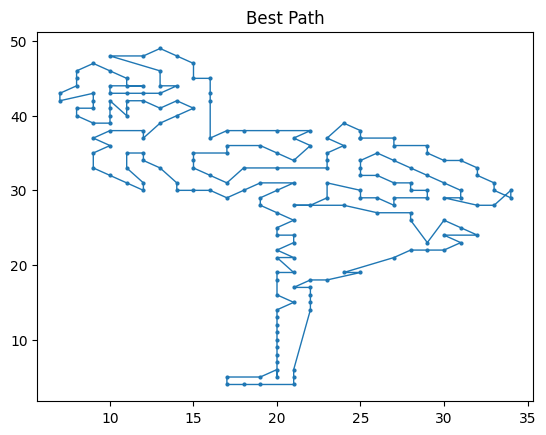

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	3115.75	3308.82
1  	43    	311.03 	2653.26
2  	39    	297.82 	1676.51
3  	39    	297.82 	734.927
4  	42    	293.82 	344.936
5  	45    	293.82 	343.128
6  	32    	293.82 	328.89 
7  	38    	293.056	324.473
8  	36    	293.056	318.19 
9  	40    	293.056	325.947
10 	41    	292.405	314.463


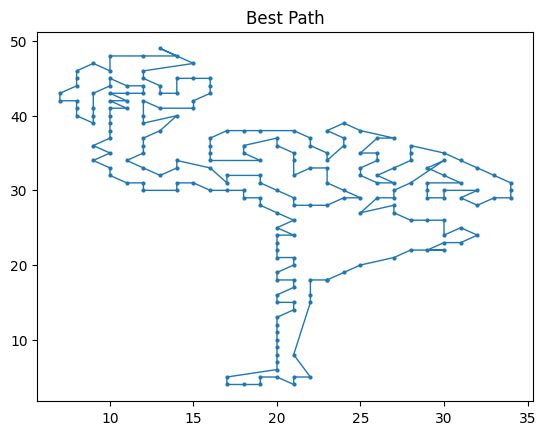

Solving TSP for red
gen	nevals	min    	avg   
0  	50    	2543.59	2818.5
1  	31    	288.169	2465.64
2  	41    	276.951	1472.35
3  	40    	288.169	562.352
4  	39    	279.368	350.876
5  	41    	277.694	325.03 
6  	36    	277.694	317.959
7  	39    	270.839	319.979
8  	41    	272.836	317.259
9  	34    	272.836	296.874
10 	37    	272.836	299.944


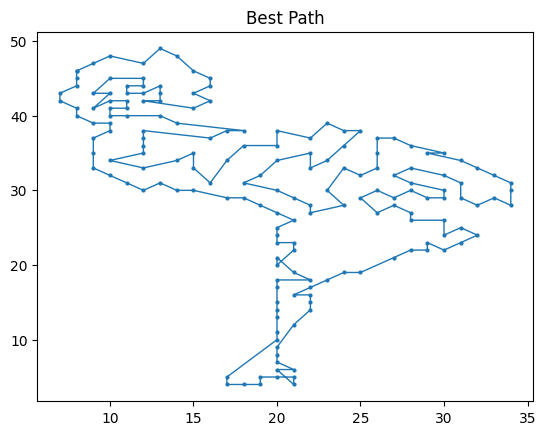

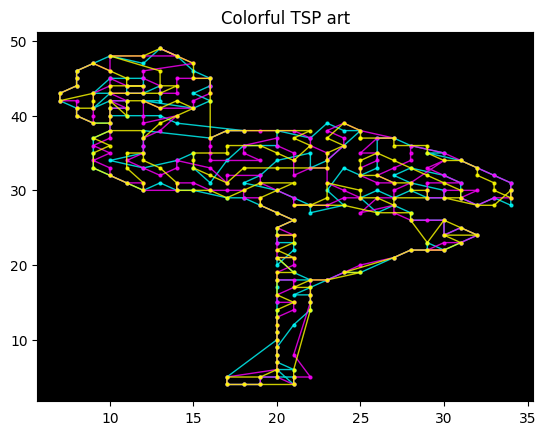

Solving TSP for blue
gen	nevals	min    	avg    
0  	50    	4844.43	5011.08
1  	39    	455.347	4045   
2  	40    	445.129	1854.68
3  	41    	448.21 	571.411
4  	37    	439.239	481.197
5  	38    	439.239	475.66 
6  	36    	439.239	470.566
7  	35    	439.239	465    
8  	39    	439.239	460.491
9  	42    	437.925	451.161
10 	36    	437.925	447.236


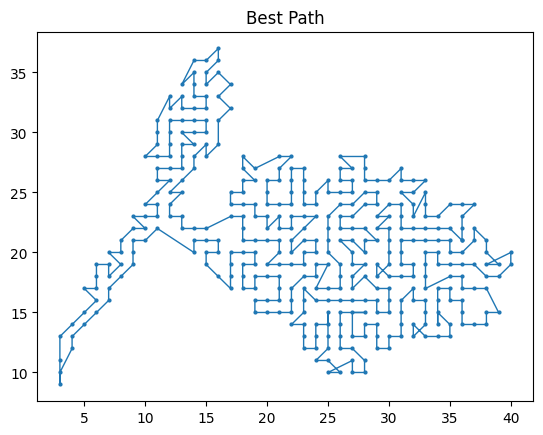

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	2848.04	3149.32
1  	42    	334.563	2455.84
2  	36    	334.396	1344.58
3  	37    	329.935	453.383
4  	39    	321.855	366.753
5  	37    	325.12 	355.481
6  	35    	324.318	352.303
7  	33    	325.12 	348.33 
8  	42    	325.12 	353.364
9  	41    	319.888	350.727
10 	41    	323.837	347.761


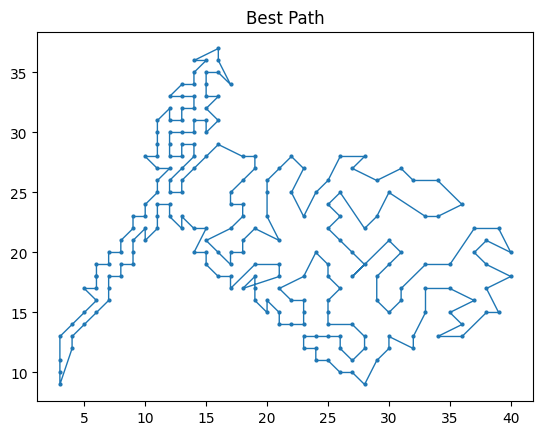

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	2694.64	2903.55
1  	35    	315.707	2349.12
2  	34    	312.51 	1422.74
3  	35    	310.278	503.813
4  	38    	307.229	356.059
5  	40    	307.229	347.646
6  	35    	307.229	340.542
7  	42    	307.229	337.353
8  	35    	301.402	335.263
9  	44    	301.761	339.44 
10 	34    	303.354	329.01 


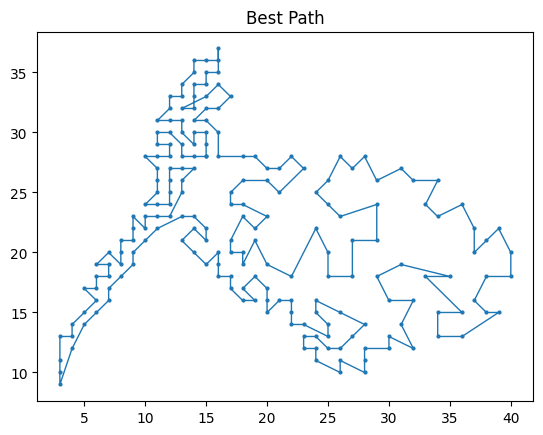

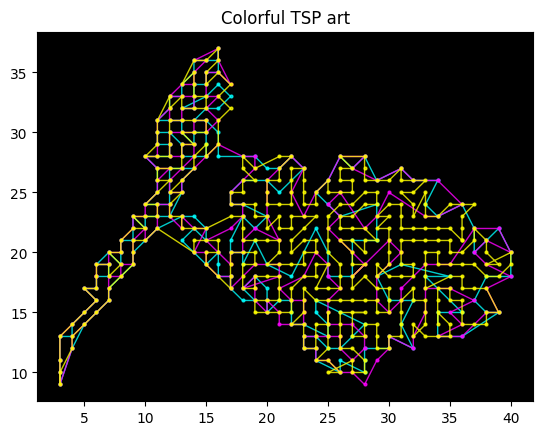

Solving TSP for blue
gen	nevals	min  	avg    
0  	50    	10275	10843.1
1  	32    	808.976	9518.22
2  	37    	802.314	6589.85
3  	47    	794.188	1751.82
4  	36    	787.634	872.31 
5  	35    	785.238	857.728
6  	41    	785.238	846.713
7  	35    	788.748	830.747
8  	41    	791.554	838.243
9  	41    	789.5  	836.876
10 	41    	781.887	842.22 


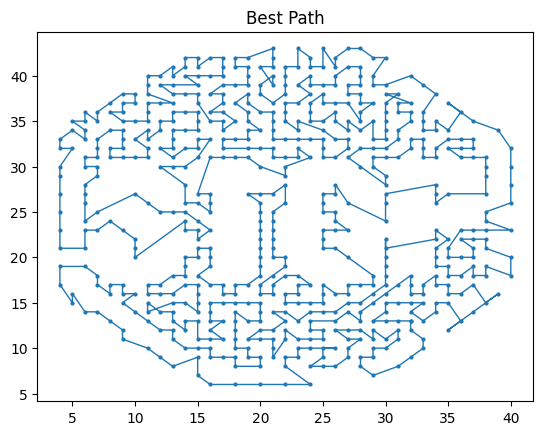

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	11988.8	12557.9
1  	42    	892.518	8501.11
2  	39    	895.292	4578.75
3  	39    	895.292	1093.6 
4  	37    	884.747	940.59 
5  	43    	891.62 	954.947
6  	49    	887.411	967.595
7  	38    	884.258	948.732
8  	39    	884.258	946.978
9  	38    	884.258	936.893
10 	38    	878.143	937.039


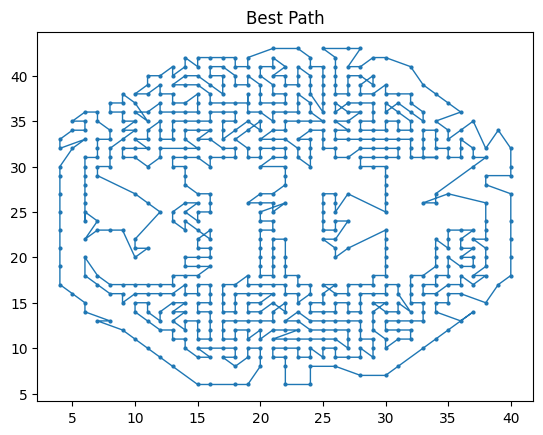

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	4721.02	5094.52
1  	38    	556.358	4098.99
2  	37    	552.523	2196.44
3  	44    	537.266	714.252
4  	36    	536.878	602.503
5  	39    	536.878	581.534
6  	35    	536.878	580.783
7  	40    	534.942	581.892
8  	38    	534.054	581.351
9  	37    	532.887	585.141
10 	40    	533.889	583.656


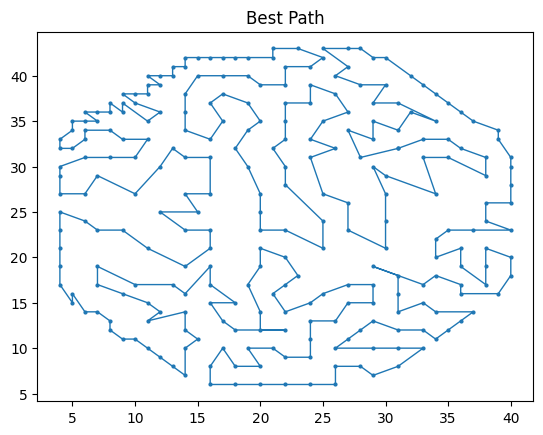

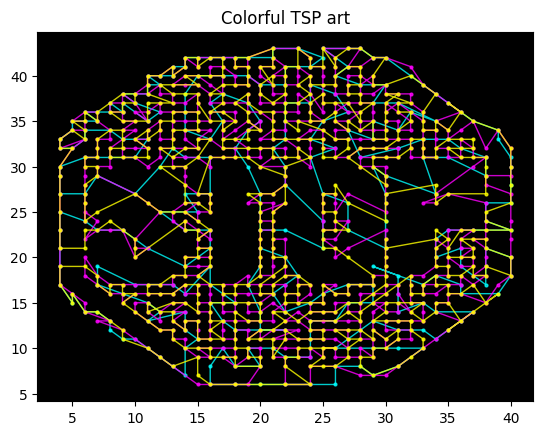

Solving TSP for blue
gen	nevals	min    	avg    
0  	50    	9184.39	9585.27
1  	40    	745.754	6794.15
2  	40    	741.81 	2856.79
3  	37    	735.031	916.74 
4  	39    	741.81 	792.419
5  	29    	741.81 	782.697
6  	38    	727.766	777.526
7  	38    	727.766	771.962
8  	38    	727.766	763.988
9  	37    	726.058	760.533
10 	33    	716.664	757.289


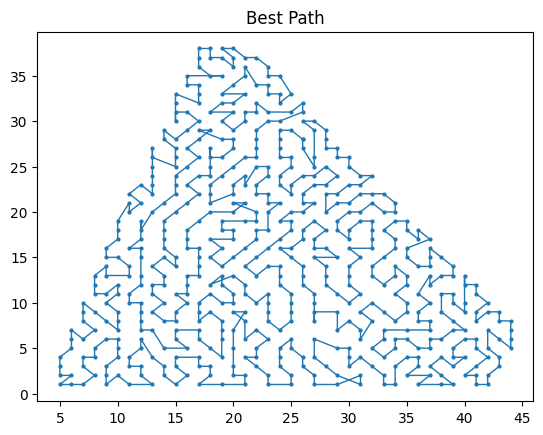

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	11123.3	11436.6
1  	40    	836.059	9639.74
2  	42    	811.412	4655.09
3  	39    	811.412	1775.18
4  	36    	810.323	872.396
5  	35    	808.27 	866.648
6  	33    	808.27 	862.757
7  	42    	808.27 	858.278
8  	37    	808.27 	852.629
9  	38    	806.666	849.538
10 	30    	806.666	849.725


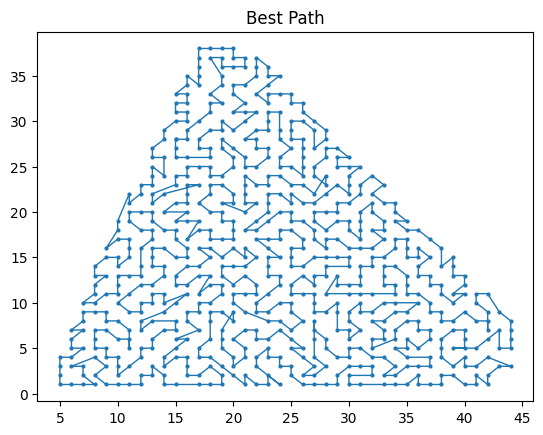

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	8969.91	9392.42
1  	39    	745.6  	8069.12
2  	38    	745.6  	5319.01
3  	41    	733.641	2002.64
4  	43    	728.382	876.032
5  	35    	723.781	778.496
6  	34    	725.69 	765.931
7  	30    	725.69 	764.674
8  	35    	722.559	761.674
9  	37    	720.47 	763.679
10 	41    	712.124	758.143


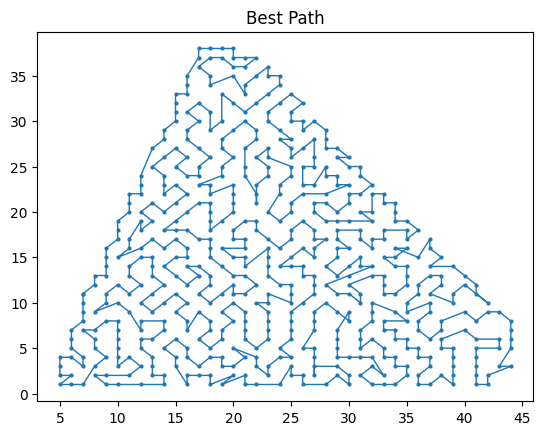

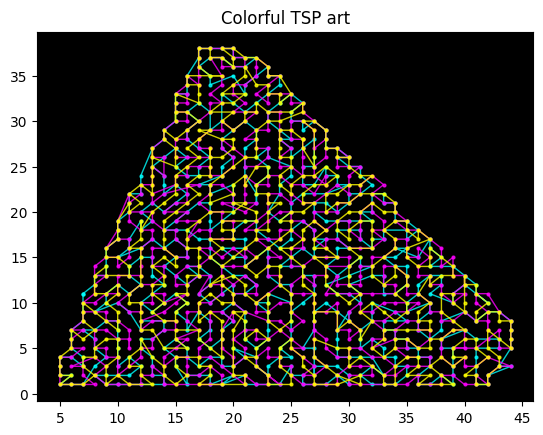

Solving TSP for blue
gen	nevals	min    	avg    
0  	50    	22522.8	23283.7
1  	36    	1396.27	17872.6
2  	35    	1389.33	9226.67
3  	44    	1371.26	1700.41
4  	26    	1371.26	1446.44
5  	29    	1371.26	1447.48
6  	38    	1371.26	1438.34
7  	39    	1365.98	1416.19
8  	34    	1364.23	1409.23
9  	37    	1361.91	1410.95
10 	40    	1358.25	1403.87


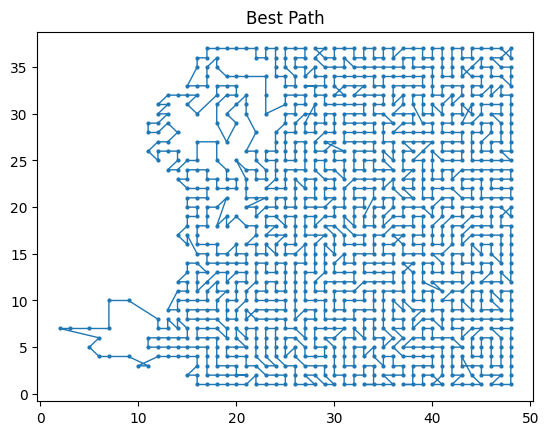

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	22538.1	23058.2
1  	36    	1388.42	18951.7
2  	40    	1358.11	13169.9
3  	32    	1358.53	5017.5 
4  	36    	1356.95	1679.54
5  	39    	1356.42	1437.39
6  	42    	1354.29	1412.22
7  	37    	1350.86	1411.09
8  	40    	1350.86	1384.67
9  	42    	1346.03	1401.86
10 	31    	1346.03	1383.75


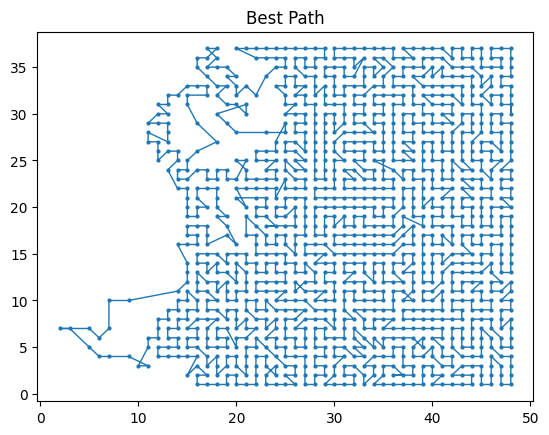

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	22485.9	23043.6
1  	35    	1396.48	19001.5
2  	36    	1367.25	7224.24
3  	40    	1364.41	2063.14
4  	34    	1361.32	1511.23
5  	46    	1353.34	1436.87
6  	37    	1352.74	1433.35
7  	41    	1352.25	1432.81
8  	31    	1352.25	1425.31
9  	35    	1352.25	1389.47
10 	40    	1352.25	1384.22


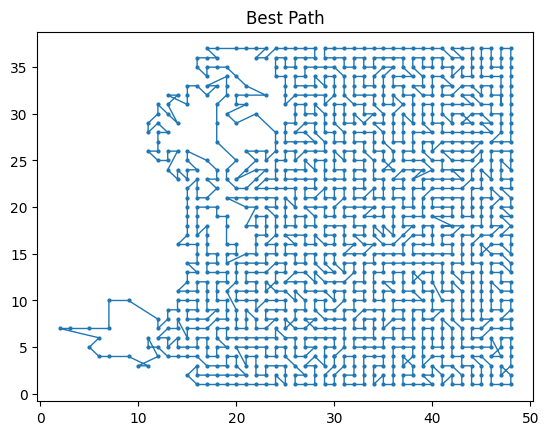

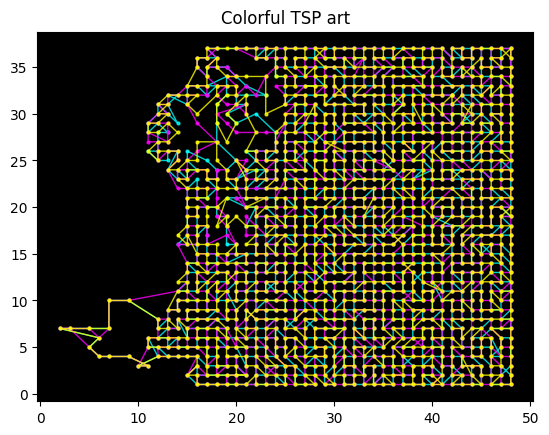

Solving TSP for blue
gen	nevals	min   	avg    
0  	50    	2369.6	2613.26
1  	41    	322.703	2374.4 
2  	39    	307.137	1285.73
3  	40    	307.137	501.058
4  	40    	310.537	347.144
5  	36    	303.467	336.996
6  	40    	304.053	332.774
7  	34    	304.053	333.555
8  	38    	303.478	334.548
9  	33    	300.817	323.338
10 	30    	300.817	314.167


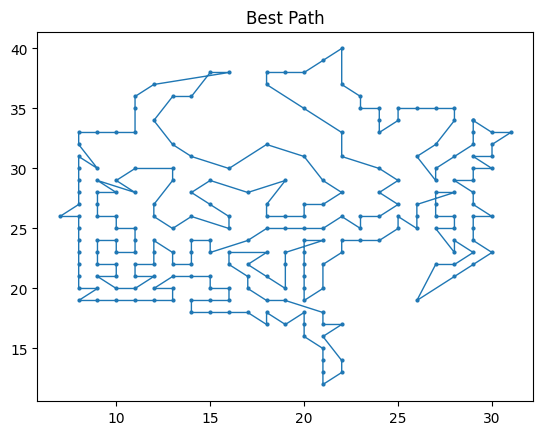

Solving TSP for green
gen	nevals	min    	avg    
0  	50    	2615.83	2789.55
1  	29    	341.958	2358.63
2  	41    	338.631	1346.09
3  	35    	336.894	489.996
4  	35    	327.134	367.133
5  	37    	328.727	356.921
6  	34    	326.274	350.715
7  	43    	326.274	352.818
8  	37    	326.107	351.267
9  	34    	326.274	347.93 
10 	33    	326.152	345.841


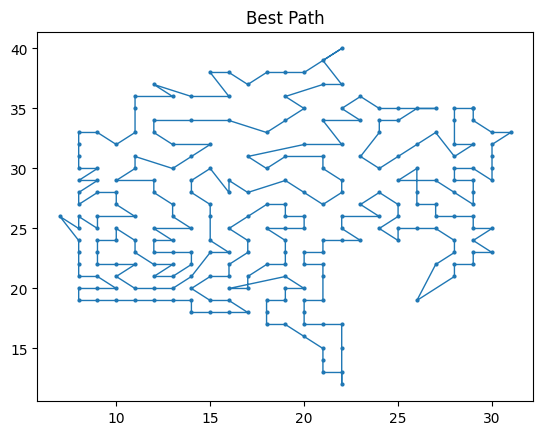

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	2099.25	2226.57
1  	40    	264.226	1684.26
2  	40    	264.739	882.611
3  	33    	262.623	400.346
4  	40    	260.482	295.628
5  	36    	255.229	292.051
6  	34    	260.482	286.699
7  	43    	257.307	285.041
8  	39    	255.258	288.614
9  	41    	255.08 	287.458
10 	37    	258.193	288.886


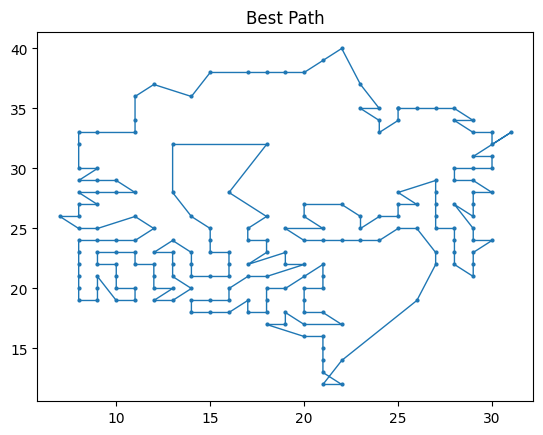

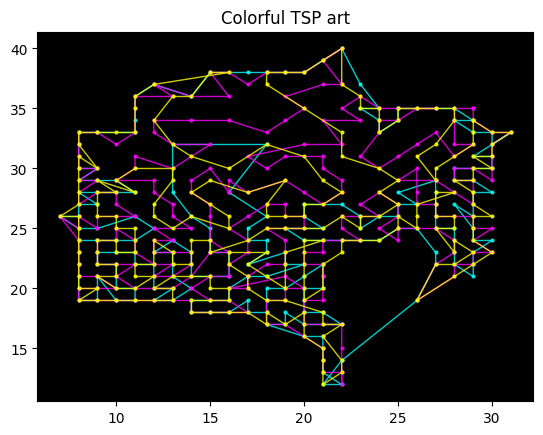

Solving TSP for blue
gen	nevals	min    	avg    
0  	50    	2053.49	2236.89
1  	39    	243.406	1834.71
2  	40    	233.982	1165.08
3  	40    	231.888	460.516
4  	34    	231.888	265.928
5  	36    	231.888	255.536
6  	40    	229.574	250.144
7  	29    	229.574	244.522
8  	37    	229.574	242.301
9  	40    	226.525	242.189
10 	36    	223.354	236.335


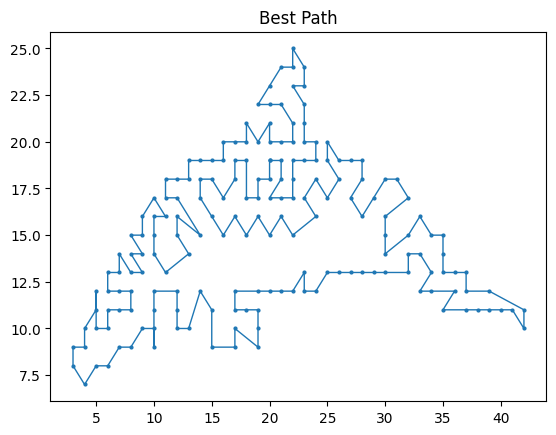

Solving TSP for green
gen	nevals	min   	avg    
0  	50    	1927.3	2126.97
1  	43    	234.736	1871.56
2  	45    	218.819	1172.35
3  	37    	218.819	435.967
4  	38    	220.082	255.544
5  	38    	220.082	246.98 
6  	40    	222.019	242.209
7  	46    	218.467	247.18 
8  	40    	218.467	243.783
9  	40    	218.467	241.892
10 	38    	218.467	242.974


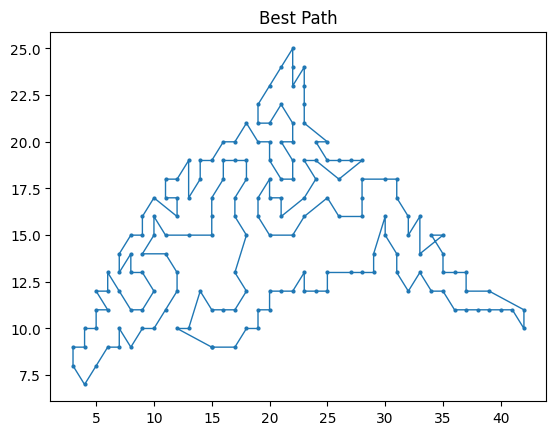

Solving TSP for red
gen	nevals	min    	avg    
0  	50    	1864.57	2026.88
1  	39    	223.696	1623.95
2  	32    	223.696	821.321
3  	32    	221.179	416.611
4  	35    	220.065	260.293
5  	36    	216.725	236.17 
6  	44    	216.725	236.703
7  	44    	214.774	238.614
8  	43    	212.201	237.355
9  	46    	213.781	238.407
10 	43    	213.781	232.621


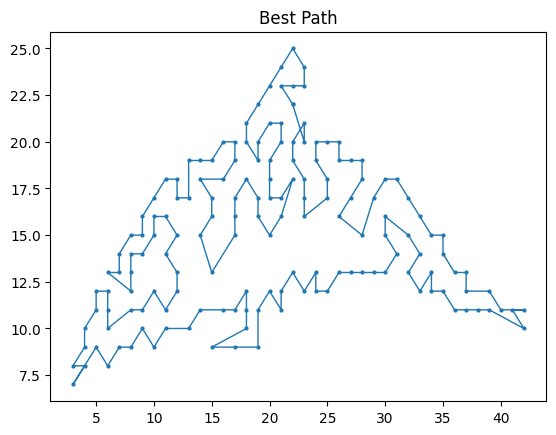

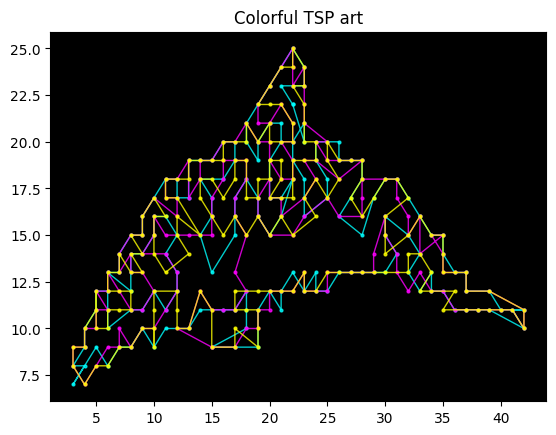

In [60]:
# We chose GA due to it's outstanding performance in our experiments

for i in range(1,11):
  path = "./exp"+str(i)+".png"
  solver = TSP_GA(path)
  solver.solve_color()